In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("../..")

In [247]:
import rasterio as rio, rasterio.windows
import matplotlib.pyplot as plt
import pandas as pd
import cv2

import shapely as shp, shapely.geometry
from shapely.geometry import mapping

import torch, torch.nn
import fiona

import detectron2 as dt, detectron2.config, detectron2.checkpoint, detectron2.engine, detectron2.utils.visualizer
from src.utils.image_processing import sliding_window_iterator
import tqdm

In [12]:
# from src.orthophotomap.patches_iterator import SimplePatchesIterator
from src.orthophotomap.forest_iterator import ForestIterator

In [6]:
# CFG = detectron2.config.get_cfg()
# CFG.merge_from_file("./tboard_logs/retinanet_test_2020-01-21T23:40/config.yml")
cfg = dt.config.CfgNode(dt.config.CfgNode.load_yaml_with_base("./tboard_logs/only_rgb_retinanet_augm_2020-02-26T12:30/config.yml"))


In [9]:
cfg.MODEL.WEIGHTS = "./tboard_logs/only_rgb_retinanet_augm_2020-02-26T12:30/model_0349999.pth"
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.25

In [10]:
predictor = dt.engine.DefaultPredictor(cfg)

In [263]:
RGB = "/mnt/SAMSUNG/datasets/bzbuas/forests/ML_dane_dla_kola/Sulechow_slawa/RGB_sulechow_slawa.tif"
OBSZAR = "/mnt/SAMSUNG/datasets/bzbuas/forests/ML_dane_dla_kola/Sulechow_slawa/obszar_sulechow_slawa.shp"

In [249]:
fi = ForestIterator(RGB,
#                     "/mnt/SAMSUNG/datasets/bzbuas/forests/ML_dane_dla_kola/Sulechow_slawa/drzewa_sulechow_slawa.shp",
                    OBSZAR,
                    channels_first=False,
#                     apply_mask=False,
#                     tb_margin=25, lr_margin=25
                   )

In [268]:
from src.detection.ml_detection import SickTreesDetectron2Detector

In [277]:
detector = SickTreesDetectron2Detector("tboard_logs/only_rgb_retinanet_augm_2020-02-26T12:30/config.yml",
                                       "tboard_logs/only_rgb_retinanet_augm_2020-02-26T12:30/model_0349999.pth")

In [279]:
res = detector.detect(fi[1]['rgb'])

In [281]:
res[:2]

[{'row_min': 130,
  'row_max': 182,
  'col_min': 466,
  'col_max': 510,
  'score': 0.12599371373653412,
  'box': (130, 466, 182, 510)},
 {'row_min': 166,
  'row_max': 217,
  'col_min': 391,
  'col_max': 427,
  'score': 0.12041931599378586,
  'box': (166, 391, 217, 427)}]

In [288]:
predictions = []
# for forest in tqdm.notebook.tqdm(fi):
for forest in tqdm.notebook.tqdm([fi[0], fi[1]]):
    img = forest['rgb']
    img = img[:,:,::-1]
    for pred in detector.detect(forest['rgb']):
        predictions.append({
            "row_min": pred["row_min"] + forest["row_min"],
            "col_min": pred["col_min"] + forest["col_min"],
            "row_max": pred["row_max"] + forest["row_max"],
            "col_max": pred["col_max"] + forest["col_max"],
            "score": pred["score"]
        })

In [290]:
min([p['score'] for p in predictions])

0.05014132335782051

In [287]:
preds = []
for forest in tqdm.notebook.tqdm(fi):
# for forest in tqdm.notebook.tqdm([fi[0], fi[1]]):
    img = forest['rgb']
    img = img[:,:,::-1]
#     for row, col, wind in tqdm.notebook.tqdm(sliding_window_iterator(img, 256)):
#         if not (wind == 0).all():
#             preds.append({'pred': predictor(wind),
#                           'img': img[:,:,::-1],
#                           'row': forest['row_min'] + row,
#                           'col': forest['col_min'] + col})

In [43]:
# with rio.open("./data/szprotawa/RGB_szprotawa_transparent_mosaic_group1.tif") as f:
#     spi = SimplePatchesIterator(f, 256, 256, 0, 2048*4, 0, 2048*4)
#     preds = []
    
#     for patch in spi():
#         img = patch['image'][:,:,:-1]
#         img = img[:,:,::-1]
#         preds.append({'pred': predictor(img),
#                       'img': img,
#                       'row': patch['row_offset'],
#                       'col': patch['col_offset']})

In [264]:
geoms = []
i = 0
with rio.open(RGB) as f:
    for d in preds:
        r, c = d['row'], d['col']

        for b in d['pred']["instances"].pred_boxes.tensor:
            c0, r0, c1, r1 = b.cpu().numpy()

            r0, c0 = r + r0, c + c0
            r1, c1 = r + r1, c + c1

            x0, y0 = f.xy(r0,c0)
            x1, y1 = f.xy(r1,c1)

            geom = {"geometry": mapping(shp.geometry.box(min(x0,x1),min(y0,y1),
                                                         max(x0, x1), max(y0,y1))),
                   'properties':{'id': i}}

            geoms.append(geom)
            i+=1

In [265]:
schema = {
    'geometry': 'Polygon',
    'properties': {'id': 'int'}}

In [266]:
!mkdir sulechow_shp

In [267]:
with fiona.open('sulechow_shp/sulechow_shp.shp', 'w', 'ESRI Shapefile', schema) as c:
    ## If there are multiple geometries, put the "for" loop here
    for g in geoms:
        c.write(g)

In [250]:
im.shape

(1536, 2048, 3)

In [81]:
c0, r0, c1, r1 = d['pred']["instances"].pred_boxes[0].tensor[0].cpu().numpy()

c0, r0 = f.xy(r + r0, c + c0)
c1, r1 = f.xy(r + r1, c + c1)

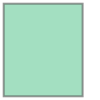

In [80]:
shp.geometry.box(x0,y0,x1,y1)

In [84]:
from shapely.geometry import mapping

In [85]:
mapping(shp.geometry.box(x0,y0,x1,y1))

{'type': 'Polygon',
 'coordinates': (((185.67901611328125, 134.4528350830078),
   (185.67901611328125, 226.08450317382812),
   (107.58787536621094, 226.08450317382812),
   (107.58787536621094, 134.4528350830078),
   (185.67901611328125, 134.4528350830078)),)}

In [2]:
import cv2

In [3]:
im = cv2.imread("/home/mkosturek/Downloads/volvo_zdjecie_pogladowe_mkosturek.jpg")[:,:,::-1]

In [9]:
cv2.imwrite('test.png', im)

True

In [13]:
im = cv2.imread("test.png")#[:,:,::-1]

In [16]:
im = cv2.imread("data/szprotawa/szprotawa_patches_256/patch_26423.png")

In [7]:
import numpy as np

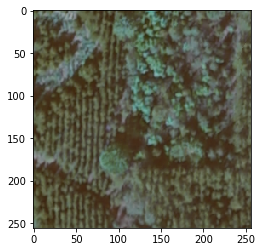

In [24]:
im = cv2.imread("data/szprotawa/szprotawa_patches_256/patch_44123.png")#[:,:,::-1]
plt.imshow(im)

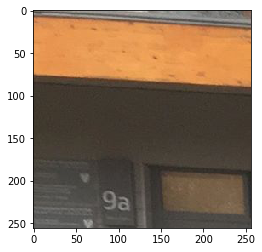

In [157]:
plt.imshow(np.lib.stride_tricks.as_strided(im, (256,256, 3)))

In [168]:
import numpy as np

n = 10
N = 20

x       = np.arange(N)
y       = np.arange(100,N+100)

Z       = np.vstack((x, y))

def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    print(shape)
    strides = a.strides + (a.strides[-1],)
    print(strides)
    return np.lib.stride_tricks.as_strided(a, shape=shape, 
                                           strides=strides)


rZ = rolling_window(Z, n)

(2, 11, 10)
(160, 8, 8)


In [169]:
Z.shape

(2, 20)

In [164]:
1+2

3

In [163]:
Z.shape

(2, 20)

In [167]:
np.lib.stride_tricks.as_strided(im, shape=(256,256,3), 
                                strides=(256,256, 0)).shape


(256, 256, 3)

In [170]:
im.strides

(6144, 3, -1)

In [171]:
im.shape

(1536, 2048, 3)

In [177]:
a=np.ndenumerate(im)
next(a)
next(a)

((0, 0, 1), 143)

In [179]:
def sliding_window(arr, window=3):
    i = iter(arr)
    a = []
    for e in range(0, window): 
        a.append(next(i))
    yield a
    for e in i:
        a = a[1:] + [e]
        yield a

In [180]:
sw = sliding_window(im, 256)

In [184]:
a = next(sw)

In [189]:
a[0].shape

(2048, 3)

In [190]:
def sliding_window(image, stepSize, windowSize):
	# slide a window across the image
	for y in range(0, image.shape[0], stepSize):
		for x in range(0, image.shape[1], stepSize):
			# yield the current window
			yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [236]:
sw = sliding_window(im, 1000, (1000,1000))

In [239]:
a = next(sw)
a[:2], a[2].shape

((2000, 0), (1000, 48, 3))

In [233]:
next(sw)[2].shape

(256, 256, 3)

In [241]:
d['pred']

{'instances': Instances(num_instances=2, image_height=256, image_width=256, fields=[pred_boxes = Boxes(tensor([[107.5879, 134.4528, 185.6790, 226.0845],
         [130.2127,  24.9315, 256.0000, 174.8969]], device='cuda:0')), scores = tensor([0.7316, 0.4578], device='cuda:0'), pred_classes = tensor([0, 0], device='cuda:0'), ])}

In [243]:
d['pred']['instances']

Instances(num_instances=2, image_height=256, image_width=256, fields=[pred_boxes = Boxes(tensor([[107.5879, 134.4528, 185.6790, 226.0845],
        [130.2127,  24.9315, 256.0000, 174.8969]], device='cuda:0')), scores = tensor([0.7316, 0.4578], device='cuda:0'), pred_classes = tensor([0, 0], device='cuda:0'), ])

In [248]:
for s, b in (d['pred']['instances'].scores, d['pred']['instances'].pred_boxes):
    print(s,b)

tensor(0.7316, device='cuda:0') tensor(0.4578, device='cuda:0')
tensor([107.5879, 134.4528, 185.6790, 226.0845], device='cuda:0') tensor([130.2127,  24.9315, 256.0000, 174.8969], device='cuda:0')


Boxes(tensor([[107.5879, 134.4528, 185.6790, 226.0845],
        [130.2127,  24.9315, 256.0000, 174.8969]], device='cuda:0'))

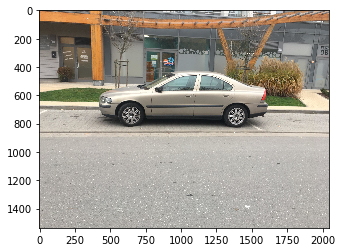

In [251]:
plt.imshow(im)

In [256]:
mask = np.random.choice([0,1], im.shape[:2]+(1,))

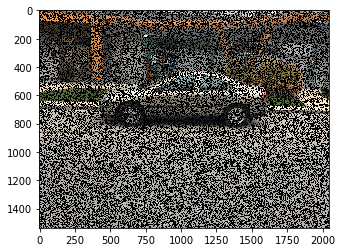

In [258]:
plt.imshow(im* mask)

In [5]:
from src.detection.ml_detection import SickTreesDetectron2Detector
from src.orthophotomap.forest_iterator import ForestIterator

In [17]:
det = SickTreesDetectron2Detector(
        "./tboard_logs/retinanet_test_2020-01-21T23:40/config.yml",
        "./tboard_logs/retinanet_test_2020-01-21T23:40/model_final.pth",
        256)

In [8]:
with rio.open("./data/szprotawa/RGB_szprotawa_transparent_mosaic_group1.tif") as f:
    part = f.read(window=rio.windows.Window(5000, 5000, 4000, 4000))
    part = part.transpose(1,2,0)[:,:,:3]

In [9]:
part.shape

(4000, 4000, 3)

In [18]:
%%time
import numpy as np
pred = det.detect(part,#[:,:,::-1], 
                  part[:,:,0].squeeze(), 
                  np.ones(part.shape[:2], dtype=np.uint8))

CPU times: user 12.9 s, sys: 1.35 s, total: 14.3 s
Wall time: 12.3 s


In [19]:
len(pred)

141

In [20]:
im_pred = part.copy()

In [21]:
for p in pred:
    im_pred = cv2.rectangle(im_pred, 
                            (int(p['col_min']), int(p['row_min'])),
                            (int(p['col_max']), int(p['row_max'])), 
                            0x00FF00, 3)

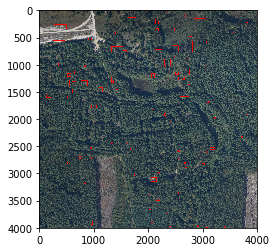

In [22]:
plt.imshow(im_pred)

In [60]:
cv2.imwrite('test.jpg',im_pred[:,:,::-1])

True

In [61]:
import torch

In [63]:
a = torch.FloatTensor([1.4, 2.551, 123.2])
a

tensor([  1.4000,   2.5510, 123.2000])

In [66]:
# a.round().
a

tensor([  1.4000,   2.5510, 123.2000])

In [69]:
a[0].to(int)

tensor(1)

In [25]:
import shapely as shp


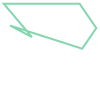

In [27]:
shp.geometry.LineString(np.asarray([[9483.0, 9461.0, 9520.0, 9533.0, 9522.0, 9466.0, 9483.0],
                                   [16706.0, 16732.0, 16732.0, 16713.0, 16697.0, 16715.0, 16706.0]]).T)

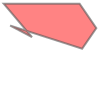

In [29]:
poly = shp.geometry.Polygon(np.asarray([[9483.0, 9461.0, 9520.0, 9533.0, 9522.0, 9466.0, 9483.0],
                                   [16706.0, 16732.0, 16732.0, 16713.0, 16697.0, 16715.0, 16706.0]]).T)
poly

In [30]:
poly.is_valid

False

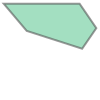

In [31]:
poly.buffer(0)